# Building Character Level Language Model

## Introduction

A **language model** assigns a probability to every sequence of words.

$$P(w_1, w_2,\dots, w_n)=P(w_1)P(w_2|w_1)P(w_3|w_1,w_2) \times \dots \times P(w_n|w_1,w_2, \dots, w_{n-1})$$

### Applications

- **Translation**: We can compare different orderings of words:
<h6 align="center">P(he likes apple) > P(apple likes he)</h6>
<br>
- **Speech Recognition**: We can choose words:
<h6 align="center">P(he likes apple) > P(apple licks he)</h6>

## Libraries

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import sys
import random
import pickle

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from utils import *
from data_utils import Vocabulary
from train_utils import train

from IPython.core.debugger import Pdb  ## DEBUGGING ##

# setup
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12., 6.)
pdb = Pdb()
use_gpu = torch.cuda.is_available()

Helper functions

In [2]:
def plot_loss(trn_hist, val_hist):
    plt.plot(trn_hist, label='Training Loss')
    plt.plot(val_hist, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

## Data

- A huge amount of texts containing bilions of words (such as all wikipedia articles).
- But here, we use a rather small corpus containing Rumi's poems (Masnavi).

<img src='imgs/Rumi.jpg' width='40%'/>

<h4 align='center'><a href='https://en.wikipedia.org/wiki/Rumi'>Statue of Rumi in Buca</a></h4>

In [3]:
data_dir = 'data/masnavi'
train_data = f'{data_dir}/masnavi.txt'

output_dir = f'{data_dir}/char/models'
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

### Statistics

In [4]:
def cal_stats(corpus_path):
    # collect the number of tokens used in each sentence of the corpus in a list
    lengths = [len(s) for s in open(corpus_path, encoding='utf8').read().split('\n')]
    
    # compute stats
    total = sum(lengths)
    mean = np.mean(lengths)
    std = np.std(lengths)
    
    # print stats
    print('Total characters in the corpus = {}\n'.format(total))
    print('Mean = {:.2f}'.format(mean))
    print('Std  = {:.2f}'.format(std))
    print('95% confidence interval = [{:.2f}, {:.2f}]'.format(mean-2*std, mean+2*std))
    
    # plot histogram
    plt.hist(lengths, bins=20)
    plt.show()

Total characters in the corpus = 683841

Mean = 50.19
Std  = 14.70
95% confidence interval = [20.80, 79.58]


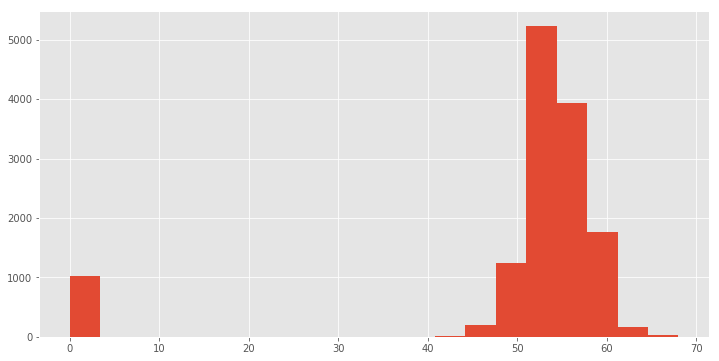

In [5]:
cal_stats(train_data)

### Corpus

In [6]:
class Corpus(object):
    
    def __init__(self, corpus_path):
        self.vocabulary = Vocabulary()
        self.corpus_path = corpus_path
        self.num_sentences = len([line for line in open(corpus_path, encoding='utf8')])
    
    def get_data(self, batch_size=20, split_ratio=0.2):
        
        # First pass: add words to the vocabulary
        trn_tokens, val_tokens = [], []
        with open(self.corpus_path, encoding='utf8') as f:
            for line in tqdm_notebook(f, desc='Building Vocab...', total=self.num_sentences):
                tokens = line
                if len(line) <= 10: continue
                if random.random() < split_ratio:
                    val_tokens += tokens
                else:
                    trn_tokens += tokens
        
        counter = Counter(trn_tokens + val_tokens)        
        vocabs = [(w, c) for (w, c) in counter.items()]
        
        for i, (word, count) in enumerate(sorted(vocabs, key=lambda x: x[1], reverse=True)):
            self.vocabulary.word2index[word] = i
            self.vocabulary.word2count[word] = count
            self.vocabulary.index2word[i] = word
            self.vocabulary.num_words += 1        
        
        # Second pass: Tokenize file content        
        # train ids
        trn_ids = torch.LongTensor(len(trn_tokens))
        for idx, token in enumerate(trn_tokens):
            trn_ids[idx] = self.vocabulary.word2index[token] 
        
        # validation ids
        val_ids = torch.LongTensor(len(val_tokens))
        for idx, token in enumerate(val_tokens):
            val_ids[idx] = self.vocabulary.word2index[token] 
        
        num_batches = trn_ids.size(0) // batch_size
        trn_ids = trn_ids[: num_batches * batch_size]
        
        num_batches = val_ids.size(0) // batch_size
        val_ids = trn_ids[: num_batches * batch_size]

        return trn_ids.view(batch_size, -1), val_ids.view(batch_size, -1)

### Hyper-parameters

In [7]:
# LSTM hyper-parameters
embed_size = 1500
hidden_size = 1500
num_layers = 2

# Training hyper-parameters
num_epochs = 40
batch_size = 50
seq_length = 150
learning_rate = 0.001

### Load Data

In [8]:
corpus = Corpus(train_data)
trn_ids, val_ids = corpus.get_data(batch_size)
vocab_size = len(corpus.vocabulary)

# save vocabs and ids
pickle.dump(corpus.vocabulary, open(f'{output_dir}/vocab.pkl', 'wb'))
np.save(f'{output_dir}/trn_ids.npy', trn_ids.view(-1).numpy())
np.save(f'{output_dir}/val_ids.npy', val_ids.view(-1).numpy())

HBox(children=(IntProgress(value=0, description='Building Vocab...', max=13625), HTML(value='')))

In [9]:
vocab_size = len(corpus.vocabulary)
print(vocab_size)
print(trn_ids.size())
print(val_ids.size())

50
torch.Size([50, 11082])
torch.Size([50, 2845])


In [10]:
most_commons = [(w, c) for (w, c) in corpus.vocabulary.word2count.items()][:20]

for w, c in most_commons:
    print(w, c)

  157824
ا 61981
ن 43565
ی 43192
ر 42110
د 38605
و 35868
م 26767
ت 23417
ه 23416
ب 23341
ش 15988
س 15975
ک 15594
ز 13716

 12592
ل 11832
گ 9934
خ 8874
	 8192


## LSTM For Language Modeling

In [11]:
class LSTM_LM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, drop=0.35, tie=True):
        super(LSTM_LM, self).__init__()
        
        if tie:
            embed_size = hidden_size
        
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
            
        self.dropout = nn.Dropout(drop)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.35)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        if tie:
            # Use the same weights both for embedding and classification
            self.fc.weight.data = self.embedding.weight.data
            
        self.init_weights()
        
    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        
    def init_hidden(self, batch_size):
        return (to_var(torch.zeros(self.num_layers, batch_size, self.hidden_size)),
                to_var(torch.zeros(self.num_layers, batch_size, self.hidden_size)))
        
    def forward(self, x, hidden):
        # embed word ids to vectors
        x = self.embedding(x)
        x = self.dropout(x)  # DROPOUT
        
        # forward RNN step
        x, hidden = self.lstm(x, hidden)
        x = self.dropout(x)  # DROPOUT
        
        # reshape output to (bs * seq_length, hidden_size)
        x = x.contiguous().view(x.size(0) * x.size(1), x.size(2))
        
        # decode hidden states of all time steps
        x = self.fc(x)
        
        return x, hidden
    
    def save(self, epoch, loss, save_to=output_dir):
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
        filename = output_dir + '/lm-masnavi-char-epoch-{}-em-{}-hi-{}-nl-{}-{:.2f}-{:.2f}.pth'.format(
            epoch, self.embed_size, self.hidden_size, self.num_layers, loss, np.exp(loss))
        torch.save(self.state_dict(), filename)

#### Tie Weights (Embedding and classification)

<h6>Idea:</h6> Reuse Embeddings for Classification, which greatly reduces the number of trainable parameters:
- [Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling (Inan et al. 2016)](https://arxiv.org/pdf/1611.01462.pdf)

### Define model

In [12]:
# model
model = LSTM_LM(vocab_size, embed_size, hidden_size, num_layers, drop=0.65)
if use_gpu:
    model = model.cuda()

# loss function
criterion = nn.CrossEntropyLoss()
if use_gpu:
    criterion = criterion.cuda()
    
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

### Training

In [13]:
hist = train(model, trn_ids, val_ids, 
             criterion, optimizer, scheduler, 
             num_epochs, batch_size, seq_length)

Validation: Epoch [40/40], Step [18/18], Loss: 0.531, Perp: 1.70, Acc: 0.91           

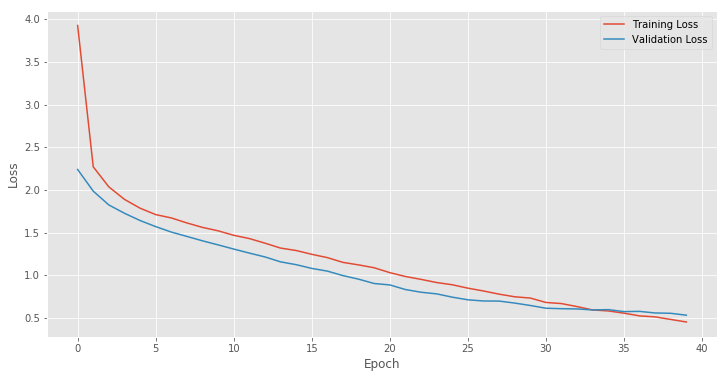

In [14]:
plot_loss(*hist)

In [15]:
torch.save(model.state_dict(), 'masnavi-lm-char-10-1500-2.pth')

### Sampling

<h6>Algorithm:</h6>
1. **Initialize** the LSTM state (`h`, `c`) with zeros.

2. Pick a **random word** from vocabulary as the seed.

3. while number of generated samples is less than the desired:
 
 3.1 **Feed** the LSTM using the word generated from previous time-step.
 
 3.2 Perform **forward computations** to create the probabilty distribution vector for vocabularies.
 
 3.3 Pick a **random word** from vocabulary according to the probabilty distribution from LSTM.

In [ ]:
def get_sample(model, sample_len):
    model.eval()
    sample = ''
    state = model.init_hidden(1)

    # select a random word id to start sampling
    probs = torch.ones(vocab_size)
    inp = to_var(torch.multinomial(probs, num_samples=1).unsqueeze(1), volatile=True)

    for i in tqdm_notebook(range(sample_len)):
        output, state = model(inp, state)

        # Sample an id
#         pdb.set_trace()
        probs = output.squeeze().data.exp().cpu()
        char_id = torch.multinomial(probs, 1)[0]

        # Feed sampled word id to next time step
        inp.data.fill_(char_id)

        # write to file
        sample += corpus.vocabulary.index2word[char_id]
    
    return sample

In [ ]:
sample = get_sample(model, 2000)
print(sample)

In [ ]:
with open('sample.txt', 'w', encoding='utf8') as f:
    f.write(sample)

## Load a pre-trained Model

In [ ]:
model = LSTM_LM(vocab_size, embed_size=1500, hidden_size=1500, num_layers=2)
model.load_state_dict(torch.load('masnavi-lm-char-10-1500-2.pth'))
if use_gpu:
    model = model.cuda()

In [ ]:
sample = get_sample(model, 2000)
print(sample)

Droput is ineffective for recurrent layers (evantually all hidden units goes to zero)
- Easy solution: use dropout only at the input and output of recurrent layers.
- Also, it is possible and common to use dropout between recurrent layers at different depths.

```python
def forward(self, inp, hidden):
    # embed word ids to vectors
    x = self.embedding(inp)
    x = self.dropout(x)  ### DROPOUT ###
        
    # forward RNN step
    x, hidden = self.lstm(x, hidden)
    x = self.dropout(x)  ### DROPOUT ###
    ...
```

## Other Language Models

- Sub-word level language models
- Character level language models

## Furthere Reading

- [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- [Oxford Deep NLP 2017 course](https://github.com/oxford-cs-deepnlp-2017/lectures)
- [Natural Language Processing with Deep Learning - Stanford](https://youtu.be/OQQ-W_63UgQ)
- [Deep Learning Book - Chapter 10](http://www.deeplearningbook.org/contents/rnn.html)